In [3]:
import os
import yaml
import numpy as np
import insightface
import cv2
from sklearn import preprocessing


# Deploy Configuration File Parser
class DeployConfig:
    def __init__(self, conf_file):
        if not os.path.exists(conf_file):
            raise Exception('Config file path [%s] invalid!' % conf_file)

    with open(conf_file) as fp:
            configs = yaml.load(fp, Loader=yaml.FullLoader)
            deploy_conf = configs["FACE"]
            # 正数为GPU的ID，负数为使用CPU
            self.gpu_id = deploy_conf["GPU_ID"]
            self.face_db = deploy_conf["FACE_DB"]
            self.threshold = deploy_conf["THRESHOLD"]
            self.nms = deploy_conf["NMS"]

In [48]:
import uuid
 
def create_uid():
    return str(uuid.uuid1())

In [204]:
class FaceRecognition:
    def __init__(self, conf_file):
        self.config = DeployConfig(conf_file)
        # 加载人脸识别模型
        self.model = insightface.app.FaceAnalysis()
        self.model.prepare(ctx_id=self.config.gpu_id, nms=self.config.nms)
        # 人脸库的人脸特征
        self.faces_embedding = list()
        # 加载人脸库中的人脸
        self.load_faces(self.config.face_db)

    # 加载人脸库中的人脸
    def load_faces(self, face_db_path):
        if not os.path.exists(face_db_path):
            os.makedirs(face_db_path)
        for root, dirs, files in os.walk(face_db_path):
            for file in files:
                input_image = cv2.imdecode(np.fromfile(os.path.join(root, file), dtype=np.uint8), 1)
                user_id = file.split(".")[0]
                print("加载人脸：%s" % user_id)
                face = self.model.get(input_image)[0]
                embedding = np.array(face.embedding).reshape((1, -1))
                embedding = preprocessing.normalize(embedding)
                self.faces_embedding.append({
                    "user_id": user_id,
                    "feature": embedding
                })
    def recognition(self, image):
        faces = self.model.get(image)
        results = list()
        for face in faces:
            result = dict()
            # 获取人脸属性
            result["bbox"] = np.array(face.bbox).astype(np.int32).tolist()
            result["landmark"] = np.array(face.landmark).astype(np.int32).tolist()
            result["age"] = face.age
            gender = '男'
            if face.gender == 0:
                gender = '女'
            result["gender"] = gender
            # 开始人脸识别
            embedding = np.array(face.embedding).reshape((1, -1))
            embedding = preprocessing.normalize(embedding)
            result["user_id"] = "unknown"
            for com_face in self.faces_embedding:
#                 print("和%s进行对比" % com_face["user_id"])
                r, dist = self.feature_compare(embedding, com_face["feature"], self.config.threshold)
                if r:
#                     result["user_id"] = com_face["user_id"]
#                     print(result["user_id"])
                    results.append((com_face["user_id"], dist))    
        return results
    
    @staticmethod
    def feature_compare(feature1, feature2, threshold):
        diff = np.subtract(feature1, feature2)
        dist = np.sum(np.square(diff), 1)
#         print("人脸欧氏距离：%f" % dist)
        if dist < threshold:
#             print("人脸欧氏距离：%f" % dist)
            return (True,dist)
        else:
            return (False,dist)
        
    def register(self, image,file_name):
        faces = self.model.get(image)
        if len(faces) != 1:
            print("没有检测到人脸，无法注册")
            return None
        # 判断人脸是否存在
        embedding = np.array(faces[0].embedding).reshape((1, -1))
        embedding = preprocessing.normalize(embedding)
        is_exits = False
        for com_face in self.faces_embedding:
            r, dist = self.feature_compare(embedding, com_face["feature"], self.config.threshold)
            if r:
                is_exits = True
        if is_exits:
            print("人脸已存在，无法注册")
            return None
#         old_user_id = [d["user_id"] for d in self.faces_embedding]
#         user_id = get_user_id(old_user_id)
        name = file_name.split("/")[-1]
        user_id = name.split(".")[0]
#         user_id = create_uid()
        # 符合注册条件保存图片，同时把特征添加到人脸特征库中
        cv2.imencode('.png', image)[1].tofile(os.path.join(self.config.face_db, '%s.png' % user_id))
        self.faces_embedding.append({
            "user_id": user_id,
            "feature": embedding
        })
        return user_id
    

In [205]:
face_recognitio = FaceRecognition("config.yaml")
for file_name in glob.glob("./AsianFace/temp/*"):
    img = cv2.imread(file_name)
    user_id = face_recognitio.register(img,file_name)
    print(user_id)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True
047_2
051_1
057_1
003_1
074_3
019_1
012_1
091_4
013_0
001_0
066_1
085_3
015_2
034_4
037_1
029_3
036_3
087_3
076_1
064_4
044_1
081_2
043_3
095_2
092_2
005_3
004_4
067_1
006_0
031_0
007_0
055_1
022_4
033_2
016_1
042_4
068_1
062_2
083_0
046_3
020_2
093_2
086_4
099_0
073_3
098_2
021_1
026_2
008_2
032_1
071_3
017_2
094_2
088_0
059_3
077_1
060_3
079_4
056_2
024_1
025_1
048_4
041_1
070_3
010_1
035_4
011_4
065_2
063_0
084_0
040_2
039_1
002_1
089_2
069_1
078_3
027_4
096_2
050_3
053_4
049_0
080_1
075_0
061_3
045_1
023_2
082_0
000_4
009_1
097_2
072_1
030_3
058_3
054_3
018_0
090_0
038_3
014_4
028_4
052_0


In [144]:
img = cv2.imread("/home/wuyunzhao/facereg/AsianFace/095/095_0.bmp")
face_recognitio = FaceRecognition("config.yaml")
result = face_recognitio.recognition(img)
print(result)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True
加载人脸：004_0
加载人脸：073_3
加载人脸：016_1
加载人脸：027_1
加载人脸：071_3
加载人脸：079_1
加载人脸：053_2
加载人脸：087_4
加载人脸：092_2
加载人脸：020_4
加载人脸：095_2
加载人脸：086_4
加载人脸：039_2
加载人脸：043_2
加载人脸：040_0
加载人脸：090_0
加载人脸：058_3
加载人脸：021_1
加载人脸：048_4
加载人脸：066_1
加载人脸：057_1
加载人脸：008_3
加载人脸：006_0
加载人脸：033_2
加载人脸：007_1
加载人脸：044_3
加载人脸：012_1


KeyboardInterrupt: 

In [237]:
face_recognitio = FaceRecognition("config.yaml")

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True
加载人脸：008_2
加载人脸：073_3
加载人脸：016_1
加载人脸：027_4
加载人脸：071_3
加载人脸：092_2
加载人脸：031_0
加载人脸：095_2
加载人脸：042_4
加载人脸：086_4
加载人脸：090_0
加载人脸：058_3
加载人脸：021_1
加载人脸：048_4
加载人脸：066_1
加载人脸：057_1
加载人脸：070_3
加载人脸：097_2
加载人脸：006_0
加载人脸：033_2
加载人脸：049_0
加载人脸：019_1
加载人脸：050_3
加载人脸：013_0
加载人脸：012_1
加载人脸：064_4
加载人脸：074_3
加载人脸：036_3
加载人脸：015_2
加载人脸：078_3
加载人脸：065_2
加载人脸：053_4
加载人脸：010_1
加载人脸：087_3
加载人脸：098_2
加载人脸：017_2
加载人脸：005_3
加载人脸：002_1
加载人脸：035_4
加载人脸：024_1
加载人脸：003_1
加载人脸：039_1
加载人脸：029_3
加载人脸：077_1
加载人脸：091_4
加载人脸：020_2
加载人脸：093_2
加载人脸：062_2
加载人脸：076_1
加载人脸：018_0
加载人脸：059_3
加载人脸：083_0
加载人脸：014_4
加载人脸：096_2
加载人脸：044_1
加载人脸：089_2
加载人脸：032_1
加载人脸：080_1
加载人脸：088_0
加载人脸：028_4
加载人脸：034_4
加载人脸：068_1
加载人脸：041_1
加载人脸：061_3
加载人脸：038

In [262]:
from time import *
begin_time = time()
acc = 0
count = 0
error = 0
for file_dir in glob.glob("./AsianFace/0*/*"):
    img = cv2.imread(file_dir)
    result = face_recognitio.recognition(img)
    name = file_dir.split("/")[-1]
    original_user_id = name.split(".")[0]
    if result:
        result = sorted(result, key = lambda value:value[1].item())
        if result[0][0].split("_")[0] == original_user_id.split("_")[0]:
#             print(result[0])
            acc += 1
        else:
            print(file_dir)
            print(result)
        if len(result) != 1:
            error += 1
    else:
        print(f"{file_dir}没有注册")
        print()
    count += 1
    
end_time = time()
run_time = end_time -begin_time

('053_4', array([0.41855627], dtype=float32))
('053_4', array([0.22617203], dtype=float32))
('053_4', array([0.20586878], dtype=float32))
('053_4', array([0.2986275], dtype=float32))
('059_3', array([0.20690903], dtype=float32))
('059_3', array([0.22365196], dtype=float32))
('059_3', array([0.32821125], dtype=float32))
('059_3', array([0.23581633], dtype=float32))
('098_2', array([0.15325734], dtype=float32))
('098_2', array([0.5597783], dtype=float32))
('098_2', array([0.34972775], dtype=float32))
('098_2', array([0.37014925], dtype=float32))
('056_2', array([0.4944721], dtype=float32))
('056_2', array([0.53081197], dtype=float32))
('056_2', array([0.5790884], dtype=float32))
('056_2', array([0.43949848], dtype=float32))
('040_2', array([0.30276996], dtype=float32))
('040_2', array([0.16738355], dtype=float32))
('040_2', array([0.23243487], dtype=float32))
('040_2', array([0.2752854], dtype=float32))
('043_3', array([0.3054217], dtype=float32))
('043_3', array([0.18390764], dtype=floa

('093_2', array([0.32332018], dtype=float32))
('093_2', array([0.29198134], dtype=float32))
('093_2', array([0.23109835], dtype=float32))
('021_1', array([0.44739982], dtype=float32))
('021_1', array([0.39238152], dtype=float32))
('021_1', array([0.26334092], dtype=float32))
('021_1', array([0.33627346], dtype=float32))
('060_3', array([0.5498367], dtype=float32))
('060_3', array([0.29801935], dtype=float32))
('060_3', array([0.4837307], dtype=float32))
('060_3', array([0.43159148], dtype=float32))
('094_2', array([0.34664267], dtype=float32))
('094_2', array([0.40331522], dtype=float32))
('094_2', array([0.22287779], dtype=float32))
('094_2', array([0.3006575], dtype=float32))
('016_1', array([0.20067814], dtype=float32))
('016_1', array([0.35928532], dtype=float32))
('016_1', array([0.2692925], dtype=float32))
('016_1', array([0.302984], dtype=float32))
('085_3', array([0.25964224], dtype=float32))
('085_3', array([0.25437826], dtype=float32))
('085_3', array([0.3064918], dtype=float

('047_2', array([0.30678415], dtype=float32))
('028_4', array([0.43386996], dtype=float32))
('028_4', array([0.21935093], dtype=float32))
('028_4', array([0.2725933], dtype=float32))
('028_4', array([0.34134197], dtype=float32))
('033_2', array([0.329724], dtype=float32))
('033_2', array([0.2938451], dtype=float32))
('033_2', array([0.3278393], dtype=float32))
('033_2', array([0.25966528], dtype=float32))
('024_1', array([0.1429176], dtype=float32))
('024_1', array([0.27711558], dtype=float32))
('024_1', array([0.20860258], dtype=float32))
('024_1', array([0.29970878], dtype=float32))
('051_1', array([0.20565665], dtype=float32))
('051_1', array([0.27954414], dtype=float32))
('051_1', array([0.14148894], dtype=float32))
('051_1', array([0.26502877], dtype=float32))
('018_0', array([0.3210117], dtype=float32))
('018_0', array([0.17846453], dtype=float32))
('018_0', array([0.3932595], dtype=float32))
('018_0', array([0.32049468], dtype=float32))
('090_0', array([0.09130554], dtype=float3

In [263]:
run_time

16.242427110671997

In [244]:
error

0

In [245]:
count

400

In [246]:
acc

400

In [213]:
acc/count

1.0

In [236]:
5/800

0.00625

In [74]:
from IPython import display
from PIL import Image

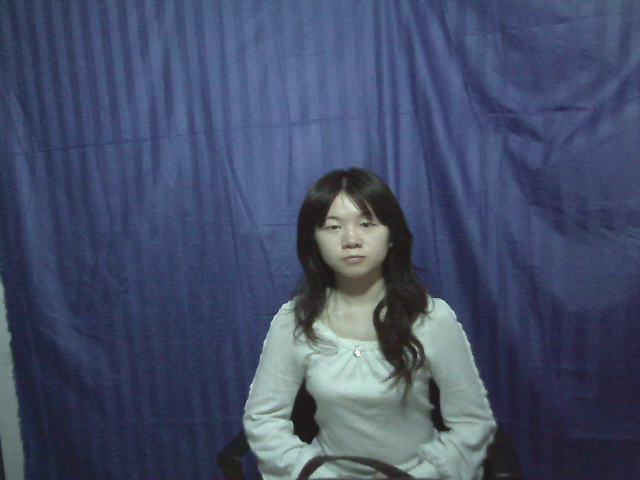

In [192]:
display.display(Image.open("./face_db/.png"))

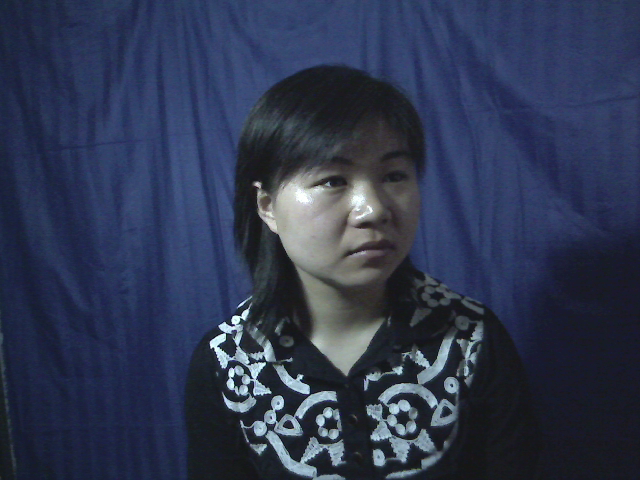

In [191]:
display.display(Image.open("./AsianFace/072/072_2.bmp"))

# 处理文件

In [21]:
import glob
import os
import shutil

In [198]:
dir_paths = glob.glob("./AsianFace/0*")

In [22]:
shutil.move("./AsianFace/test", "./AsianFace/temp/")

'./AsianFace/temp/test'

In [199]:
len(dir_paths)

100

In [200]:
for temp_dir in dir_paths:
    original_file = os.listdir(temp_dir)[0]
    target_file = "./AsianFace/temp/"
    shutil.move(os.path.join(temp_dir, original_file), target_file)